# Overlay / clipping

Data prep:
* I saved the cell providers as parquet files locally. Do this so that dask_geopandas can read it in.

Steps:
1. The cell provider maps are fairly large. Do a clipping and dissolve.
a. Use a function to do step 1. Example below does it the clipping by county. Do it either by county or district, then concatenate all the components together.
b. With the overlay, maybe it's easier to find where there's `no cell coverage`. Use `how="difference"`...there should be much smaller land area to cover with where there's no coverage.
2. Keep each cell provider in a separate gdf, but concatenate across counties/districts. Do a dissolve.
3. Do an overlay of all the routes against the dissolved-no-cell-coverage to see what portion of the routes pass through areas with no cell coverage. 

Hint: start with 1 county first and do this, maybe LA County, and work on one of the problem routes.

In [1]:
import dask.dataframe as dd
import dask_geopandas as dg
import geopandas as gpd
import pandas as pd
import utilities
from calitp import * 
from shared_utils import geography_utils

GCS_FILE_PATH = "gs://calitp-analytics-data/data-analyses/cellular_coverage/"

/opt/conda/lib/python3.9/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(


### Step 1
* Experiment with Los Angeles.

In [2]:
def get_counties():
    # California counties.
    ca_gdf = (
        "https://opendata.arcgis.com/datasets/8713ced9b78a4abb97dc130a691a8695_0.geojson"
    )
    
    my_gdf = to_snakecase(gpd.read_file(f"{ca_gdf}")
                          .to_crs("EPSG:4326"))[
        ["county_name", "geometry"]
    ]
    
    return my_gdf

In [3]:
ca_counties = get_counties()

In [4]:
#ca_counties = gpd.read_parquet("ca_counties.parquet")

# Pick a smaller area first
ca_counties = ca_counties[ca_counties.county_name == "Los Angeles"]

los_angeles = ca_counties[["geometry"]].dissolve().reset_index(drop=True)

<AxesSubplot:>

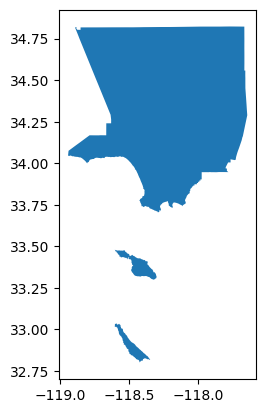

In [5]:
los_angeles.plot()

In [6]:
#counties = get_counties()

# Provider shapefiles
#verizon = utilities.load_verizon()[["geometry"]]
#att_df = utilities.load_att()[["geometry"]]
#tmobile_df = utilities.load_tmobile()[["geometry"]]


#### Find which areas of LA County doesn't intersect w/ provider

In [7]:

def find_difference_and_clip(gdf: dg.GeoDataFrame, 
                             boundary: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Clip cell provider to some boundary
    clipped = dg.clip(gdf, boundary).reset_index(drop=True) # use dask to clip
    clipped_gdf = clipped.compute() # compute converts from dask gdf to gdf
    
    # Now find the overlay, and find the difference
    # Notice which df is on the left and which is on the right
    # https://geopandas.org/en/stable/docs/user_guide/set_operations.html
    no_coverage = gpd.overlay(boundary, clipped_gdf, how = "difference")
    
    return no_coverage

####  Test with GPD instead of dask
* Break out function.
* To obtain the geometries that are part of df1 but are not contained in df2, you can use how='difference':

In [8]:
def find_difference_and_clip_gpd(gdf: gpd.GeoDataFrame, 
                             boundary: gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    # Clip cell provider to some boundary
    clipped = gpd.clip(gdf, boundary).reset_index(drop=True) 
    
    # Now find the overlay, and find the difference
    # Notice which df is on the left and which is on the right
    # https://geopandas.org/en/stable/docs/user_guide/set_operations.html
    no_coverage = gpd.overlay(boundary, clipped, how = "difference")
    
    return no_coverage

In [9]:
# verizon = dg.read_parquet("verizon.parquet")
verizon = utilities.load_verizon()[["geometry"]]

In [10]:
# Clip cell verizon map to only include los angeles.
clipped = gpd.clip(verizon, los_angeles).reset_index(drop=True) 

<AxesSubplot:>

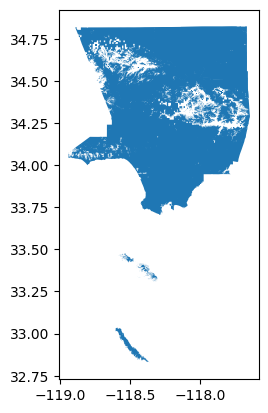

In [11]:
clipped.plot()

In [12]:
# no_coverage_test = gpd.overlay(los_angeles, clipped, how = "difference")

In [ ]:
v = find_difference_and_clip_gpd(verizon, los_angeles)

In [ ]:
# What's in LA county that's not covered by Verizon 
v.plot()

In [ ]:
att = utilities.load_att()[["geometry"]]
a = find_difference_and_clip_gpd(att, los_angeles)

In [ ]:
a.shape

In [ ]:
a.plot()

In [ ]:
# Don't look at tmobile for now since it takes longer.
# tmobile = utilities.load_tmobile()[["geometry"]]
# t = find_difference_and_clip_gpd(tmobile, los_angeles)

### Step 2: Combine with Routes

In [ ]:
routes_df = utilities.load_unique_routes_df()

In [ ]:
routes_df.shape

In [ ]:
agency_wanted = [
    "Avocado Heights/Bassett/West Valinda Shuttle",
    "Golden Gate Bridge Highway and Transportation District",
    "SamTrans",
    "MUNI",
    "Yosemite Area Regional Transportation System",
    "Los Angeles Department of Transportation"
]

routes_wanted = [
    "Edmund D. Edelman Children’s Court Shuttle",
    "Oakland - San Francisco",
    "Foster City - Hillsdale Mall",
    "24 hour service daily",
    "Mammoth Lakes HWY 120E/395",
    "Long Beach/San Pedro"
]

In [ ]:
def subset_routes(agency_wanted, routes_wanted):
    # Filter out
    routes_subset = routes_df[
        routes_df["route_name"].isin(routes_wanted)
        & routes_df["agency"].isin(agency_wanted)
    ]
    return routes_subset

In [ ]:
routes_subset = subset_routes(agency_wanted, routes_wanted)

In [ ]:
routes_subset.shape

In [ ]:
one_route = subset_routes(["Avocado Heights/Bassett/West Valinda Shuttle"], 
                               ["Edmund D. Edelman Children’s Court Shuttle"]
                              )

one_route = one_route.to_crs("EPSG:4326")

In [ ]:
one_route

In [ ]:
o1 = gpd.overlay(one_route, 
                 v, 
                 how = "intersection")

In [ ]:
o1['overlay_length'] = o1.geometry.to_crs(geography_utils.CA_StatePlane).length

In [ ]:
o1

In [ ]:
v.explore(tiles="CartoDB Positron")

In [ ]:
one_route.plot()

In [ ]:
o1.explore(tiles="CartoDB Positron")

In [ ]:
one_route.assign(
    length = one_route.geometry.length
).explore(tiles="CartoDB Positron")

In [ ]:
one_route.head(2)

In [ ]:
one_route.explode()

In [ ]:
one_route.explode().plot()

In [ ]:
group_cols = ["itp_id", "route_id"]
segmented_100ft = geography_utils.cut_segments(one_route, group_cols, 100)

In [ ]:
segmented_100ft.segment_sequence.describe()

In [ ]:
segmented_100ft.explore("segment_sequence", tiles="Carto DB Positron")

In [ ]:
s1_segmented.explore("segment_sequence", tiles="CartoDB Positron")

In [ ]:
s1 = gpd.overlay(
    one_route, 
    la_county, 
    how="intersection", 
)

s1

In [ ]:
s1_segmented = geography_utils.cut_segments(s1, group_cols, 100)

In [ ]:
s1_segmented.segment_sequence.describe()

In [ ]:
s1

In [ ]:
exploded = s1.explode(index_parts=True).reset_index()


In [ ]:
exploded = exploded.assign(
    indiv_length = exploded.geometry.length
)

In [ ]:
exploded.indiv_length.sum()

In [ ]:
exploded.level_1.max()

In [ ]:
gpd.sjoin(
    exploded,
    one_route,
    how = "left",
    predicate = "intersects"
)#.explore("level_1", categorical=True, tiles="CartoDB Positron")


In [ ]:
court_shuttle = routes_df[(routes_df.route_name.str.contains("Edmund"))]

In [ ]:
court_shuttle = court_shuttle.assign(
    route_length = court_shuttle.geometry.to_crs(geography_utils.CA_StatePlane).length
)

In [ ]:
counties2 = counties[counties.county_name=="Los Angeles"]

In [ ]:
court_shuttle.explore("route_id")

In [ ]:
one_route.overlay(
    counties2, 
    how="intersection", 
    keep_geom_type=None
).plot()

#s2 = s2.assign(
#    overlay_route_length = s2.geometry.to_crs(geography_utils.CA_StatePlane).length
#)

#s2

In [ ]:
s2.geometry.name